# Stochastic Neoclassical Growth Model

Author: Giselle Labrador Badia

September 14, 2021

## Question 1: State the dynamic programming problem

 The Dynamic Programming version of the model is

$$v(k,z) = \max_{c, k' \in \Gamma(k,s)} \log(c) + \beta \mathbb{E}[v(k',z')|z]$$

where $$c = z k^\alpha + (1-\delta) k  - k'$$

and  $\Gamma(k,s) = \{(c,k') : c \geq 0, k'\leq 0\}$




The technology shocks follow a 2 state Markov process where the values are  $\zeta = \{z^g=1.25,z^b=0.2\}$; the transition matrix is the following

$$\Pi = \begin{pmatrix}0.977 & 0.023\\0.074 & 0.926\end{pmatrix}$$

The operator $T:\mathcal{C}_{2}(\mathbb{R}_+,\zeta ) \to \mathcal{C}_{2}(\mathbb{R}_+,\zeta )$ is defined as follows

$$T \mathbf{V}(k,z)=\left\{\begin{array}{l}
\max_{c, k' \in \Gamma(k,z)} \left\{\log(c) + \beta [v(k', z^g)p_{gz} + v(k', z^b)p_{bz}]\right\}
\end{array}\right.$$

## Code 
The code below was transformed from the Julia code given as an example of the non-stochastic model.

## Parameters

In [1]:
using Parameters, Distributed

@with_kw struct Primitives
    β::Float64 = 0.99 #discount rate
    δ::Float64 = 0.025 #depreciation rate
    α::Float64 = 0.36 #capital share
    k_min::Float64 = 0.01 #capital lower bound
    k_max::Float64 = 75.0 #capital upper bound
    nk::Int64 = 1000 #number of capital grid points
    k_grid::Array{Float64,1} = collect(range(k_min, length = nk, stop = k_max)) #capital grid
    
    # Stochastic variables
    nz::Int64 = 2 #number of states 
    z_shocks::Array{Float64,2} = [1.25 0.2] #values of technology shocks
    matrix::Array{Float64,2} = [0.977  0.023; 0.074  0.926]; 
    
end

#structure that holds model results
mutable struct Results
    val_func::Array{Float64, 2} #value function  # now new dimension with two states!
    pol_func::Array{Float64, 2} #policy function # now new dimension with two states!
end



## Initialization

In [2]:

#function for initializing model primitives and results
@everywhere function Initialize()
    prim = Primitives() #initialize primtiives
    val_func = zeros(prim.nk, prim.nz) #initial value function guess
    pol_func = zeros(prim.nk,prim.nz) #initial policy function guess
    res = Results(val_func, pol_func) #initialize results struct
    prim, res #return deliverables
end

### Functions

In [3]:
function Bellman(prim::Primitives,res::Results)
    @unpack val_func = res #unpack value function
    @unpack k_grid, β, δ, α, nk,nz,z_shocks, matrix, = prim #unpack model primitives
    v_next = zeros(nk,nz) #next guess of value function to fill
    choice_lower = 1 #for exploiting monotonicity of policy function
    
    for z_index in 1:nz
        prob = matrix[z_index,:] # added prob
        z = z_shocks[z_index] #added shock
        for k_index = 1:nk
            k = k_grid[k_index] #value of k # added z_index
            candidate_max = -Inf #bad candidate max
            budget = z*k^α + (1-δ)*k #budget

            for kp_index in choice_lower:nk #loop over possible selections of k', exploiting monotonicity of policy function
                c = budget - k_grid[kp_index] #consumption given k' selection
                if c>0 #check for positivity
                    val = log(c) + β*val_func[kp_index,:]'*prob #compute value # added *prob and val_func[,:] !
                    if val>candidate_max #check for new max value
                        candidate_max = val #update max value
                        res.pol_func[k_index,z_index] = k_grid[kp_index] #update policy function # added z_index
                        #choice_lower = kp_index #update lowest possible choice # not true in this instance
                    end
                end
            end

            v_next[k_index, z_index] = candidate_max #update value function
        end

    end
    return v_next #return next guess of value function
end



Bellman (generic function with 1 method)

In [8]:
#Value function iteration
function V_iterate(prim::Primitives, res::Results; tol::Float64 = 1e-4, err::Float64 = 100.0)
    n = 0 #counter

    while err>tol #begin iteration
        v_next = Bellman(prim, res) #spit out new vectors
        err = abs.(maximum(v_next.-res.val_func))/abs(v_next[prim.nk, 1]) #reset error level
        res.val_func = v_next #update value function
        n+=1
    end
    println("Value function converged in ", n, " iterations.")
end

#solve the model
function Solve_model(prim::Primitives, res::Results)
    V_iterate(prim, res) #in this case, all we have to do is the value function iteration!
end

Solve_model (generic function with 1 method)

## Computation

In [9]:

prim, res = Initialize(); #initialize primitive and results structs
@time @elapsed Solve_model(prim, res) #solve the model!
@unpack val_func, pol_func = res
@unpack k_grid = prim


Value function converged in 434 iterations.
103.014815 seconds (903.40 M allocations: 80.783 GiB, 3.95% gc time)


Primitives
  β: Float64 0.99
  δ: Float64 0.025
  α: Float64 0.36
  k_min: Float64 0.01
  k_max: Float64 75.0
  nk: Int64 1000
  k_grid: Array{Float64}((1000,)) [0.01, 0.08506506506506506, 0.16013013013013014, 0.2351951951951952, 0.31026026026026027, 0.3853253253253253, 0.46039039039039037, 0.5354554554554555, 0.6105205205205205, 0.6855855855855856  …  74.32441441441442, 74.39947947947948, 74.47454454454454, 74.5496096096096, 74.62467467467468, 74.69973973973974, 74.7748048048048, 74.84986986986986, 74.92493493493494, 75.0]
  nz: Int64 2
  z_shocks: Array{Float64}((1, 2)) [1.25 0.2]
  matrix: Array{Float64}((2, 2)) [0.977 0.023; 0.074 0.926]


# Question 2: Value functions

The value functions are clearly concave, that is, $v(k,z)$ is concave in z or $v(k_{i+1},z)-v(k_{i},z)$ is decreasing. See plots below.

In [13]:
using Plots

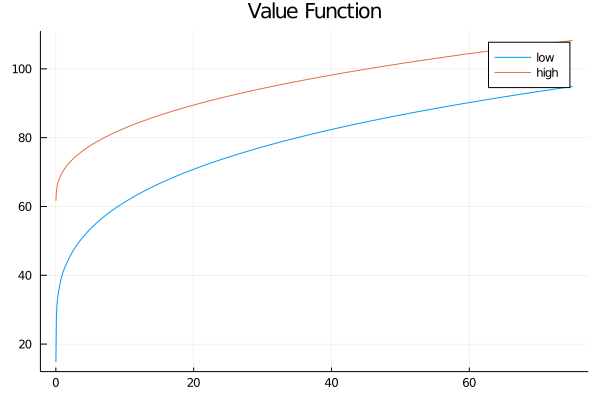

In [14]:

#value function
Plots.plot(k_grid, val_func[:,2], title="Value Function", label = "low")
Plots.plot!(k_grid, val_func[:,1], title="Value Function", label = "high")
#Plots.savefig("02_Value_Functions.png")


# Question 3: Policy functions

The policy functions are increasing in $z$ and $k$, see first plot  below. You can also check that the change in the decision rule, i.e savings  are not always increasing for the case of the good state ($z^g$, red curve) and savings are "decreasing" in k. As expected savings in the bad state are under savings in the good state for all $k$. 

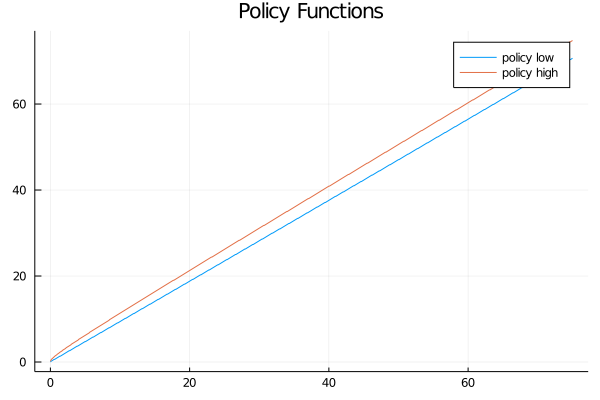

In [15]:
#policy functions
Plots.plot(k_grid, pol_func[:,2], title="Policy Functions", label = "policy low")
Plots.plot!(k_grid, pol_func[:,1], title="Policy Functions", label = "policy high")
#Plots.savefig("02_Policy_Functions.png")
Plots.plot!(k_grid, pol_func[:,1], title="Policy Functions", label = "policy high")

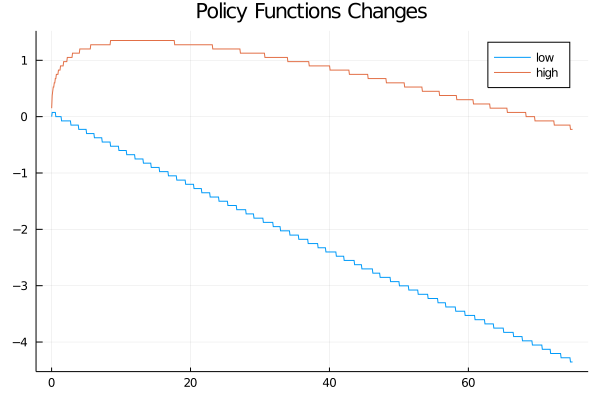

In [16]:


#changes in policy function
pol_func_δ = copy(pol_func).-k_grid
Plots.plot(k_grid, pol_func_δ[:,2], title="Policy Functions Changes",label="low")
Plots.plot!(k_grid, pol_func_δ[:,1], title="Policy Functions Changes",label="high")

#Plots.savefig("02_Policy_Functions_Changes.png")


# Parallel Programming 

Next we add parallelization to the previous code. We didn't obtain considerable improvements in efficiency. 

In [ ]:
addprocs(3)


In [ ]:
workers()
nprocs()

In [38]:
@everywhere using Distributed, SharedArrays, Parameters

@everywhere function Bellman_parall(prim::Primitives,res::Results)
    @unpack val_func = res #unpack value function
    @unpack k_grid, β, δ, α, nk,nz,z_shocks, matrix, = prim #unpack model primitives
    v_next = SharedArray{Float64}(nk,nz) #next guess of value function to fill
    pol_func_par = SharedArray{Float64}(nk,nz)
    choice_lower = 1 #for exploiting monotonicity of policy function
    
    for z_index in 1:nz
        prob = matrix[z_index,:] # added prob
        z = z_shocks[z_index] #added shock
        @sync @distributed for k_index = 1:nk
            k = k_grid[k_index] #value of k # added z_index
            candidate_max = -Inf #bad candidate max
            budget = z*k^α + (1-δ)*k #budget

            for kp_index in choice_lower:nk #loop over possible selections of k', exploiting monotonicity of policy function
                c = budget - k_grid[kp_index] #consumption given k' selection
                if c>0 #check for positivity
                    val = log(c) + β*val_func[kp_index,:]'*prob #compute value # added *prob and val_func[,:] !
                    if val>candidate_max #check for new max value
                        candidate_max = val #update max value
                        res.pol_func[k_index,z_index] = k_grid[kp_index] #update policy function # added z_index
                        #choice_lower = kp_index #update lowest possible choice # not true in this instance
                    end
                end
            end

            v_next[k_index, z_index] = candidate_max #update value function
        end

    end
    return v_next #return next guess of value function
end

#Value function iteration
function V_iterate_parall(prim::Primitives, res::Results; tol::Float64 = 1e-4, err::Float64 = 100.0)
    n = 0 #counter

    while err>tol #begin iteration
        v_next = Bellman_parall(prim, res) #spit out new vectors
        err = abs.(maximum(v_next.-res.val_func))/abs(v_next[prim.nk, 1]) #reset error level
        res.val_func = v_next #update value function
        n+=1
    end
    println("Value function converged in ", n, " iterations.")
end

#solve the model
function Solve_model_parall(prim::Primitives, res::Results)
    V_iterate_parall(prim, res) #in this case, all we have to do is the value function iteration!
end

Solve_model_parall (generic function with 1 method)

In [ ]:
prim, res = Initialize() #initialize primitive and results structs
@time @elapsed Solve_model_parall(prim, res) #solve the model

@unpack val_func, pol_func = res
@unpack k_grid = prim
